## Prepare Dependencies and Libraries

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!pip install natsort

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from natsort import natsorted

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Read Dataset

### Images

In [ ]:
# Define images path
abnormal_img_path = '/content/drive/MyDrive/dataset/images/images_v2/cropped/abnormal'
normal_img_path = '/content/drive/MyDrive/dataset/images/images_v2/cropped/normal'

In [ ]:
# Get and sort all images
normal_image_files = natsorted([f for f in os.listdir(normal_img_path) if f.lower().endswith(('.jpg', '.png'))])
abnormal_image_files = natsorted([f for f in os.listdir(abnormal_img_path) if f.lower().endswith(('.jpg', '.png'))])

# Get 2 first images
normal_images = [os.path.join(normal_img_path, f) for f in normal_image_files[:2]]
abnormal_images = [os.path.join(abnormal_img_path, f) for f in abnormal_image_files[26:29:2]]

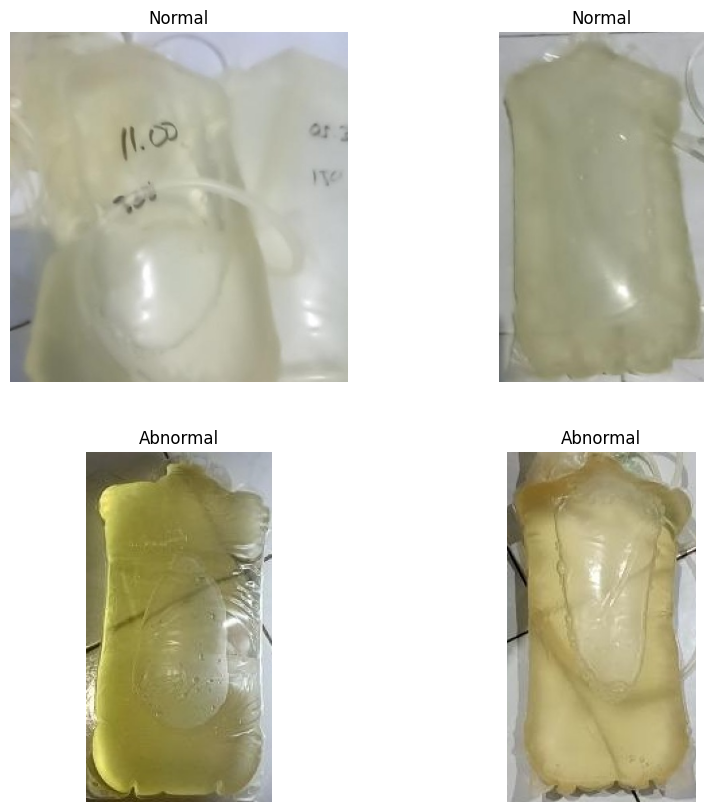

In [ ]:
# Visualize cropped images
image_paths = normal_images + abnormal_images

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row = i // 2
    col = i % 2

    axes[row, col].imshow(img)
    axes[row, col].axis("off")
    axes[row, col].set_title("Normal" if row == 0 else "Abnormal")

plt.show()

### Klinis

In [ ]:
directory = '/content/drive/MyDrive/dataset/tabular/klinis/'

In [ ]:
normal_df = pd.read_csv(os.path.join(directory, "final_normal.csv"))
abnormal_df = pd.read_csv(os.path.join(directory, "final_abnormal.csv"))

In [ ]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 342 non-null    float64
 1   foto_cairan        342 non-null    object 
 2   durasi_masuk       342 non-null    float64
 3   foto_cairan_url    342 non-null    object 
 4   volume_masuk       342 non-null    float64
 5   volume_keluar      342 non-null    float64
 6   waktu_masuk        342 non-null    object 
 7   waktu_keluar       342 non-null    object 
 8   berat_badan        342 non-null    float64
 9   tekanan_darah_mm   342 non-null    float64
 10  tekanan_darah_hg   342 non-null    float64
 11  nadi               342 non-null    float64
 12  waktu_penggantian  342 non-null    object 
 13  volume             342 non-null    float64
 14  jenis_kelamin      342 non-null    object 
 15  kondisi            342 non-null    object 
dtypes: float64(9), object(7)
m

In [ ]:
abnormal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 41 non-null     float64
 1   foto_cairan        41 non-null     object 
 2   durasi_masuk       41 non-null     float64
 3   foto_cairan_url    41 non-null     object 
 4   volume_masuk       41 non-null     float64
 5   volume_keluar      41 non-null     float64
 6   waktu_masuk        41 non-null     object 
 7   waktu_keluar       41 non-null     object 
 8   berat_badan        41 non-null     float64
 9   tekanan_darah_mm   41 non-null     float64
 10  tekanan_darah_hg   41 non-null     float64
 11  nadi               41 non-null     float64
 12  waktu_penggantian  41 non-null     object 
 13  volume             41 non-null     float64
 14  jenis_kelamin      41 non-null     object 
 15  kondisi            41 non-null     object 
dtypes: float64(9), object(7)
mem

## Exploratory Data Analysis

### Images

1. cek ukuran semua dataset
2. jumlah masing2 class

In [ ]:
def get_image_sizes(folder_path, label):
    # Use natsorted for natural sorting based on numeric parts in filenames
    image_files = natsorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
    data = []
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            data.append([img_file, width, height, label])
    return data

# Ambil ukuran gambar dari folder
abnormal_data = get_image_sizes(abnormal_img_path, "abnormal")
normal_data = get_image_sizes(normal_img_path, "normal")

# Gabungkan ke dalam DataFrame
image_size_df = pd.DataFrame(abnormal_data + normal_data, columns=["Filename", "Width", "Height", "Category"])

In [ ]:
image_size_df

,Filename,Width,Height,Category
0,abnormal-0.jpg,179,267,abnormal
1,abnormal-1.jpg,202,308,abnormal
2,abnormal-2.jpg,178,306,abnormal
3,abnormal-3.jpg,279,322,abnormal
4,abnormal-4.jpg,200,289,abnormal
...,...,...,...,...
460,normal-337.jpg,386,386,normal
461,normal-338.jpg,291,376,normal
462,normal-339.jpg,391,391,normal
463,normal-340.jpg,381,202,normal


<ipython-input-11-7200bb45551f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=['blue', 'red'])


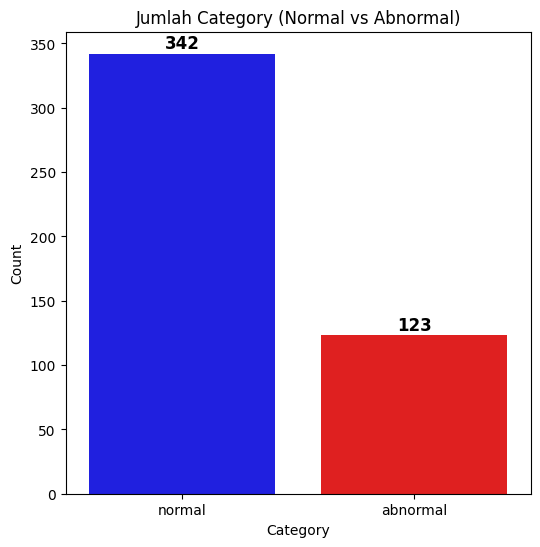

In [ ]:
category_counts = image_size_df['Category'].value_counts()

# Plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=['blue', 'red'])

# Menambahkan angka di atas bar
for i, value in enumerate(category_counts.values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labeling
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Jumlah Category (Normal vs Abnormal)")

plt.show()

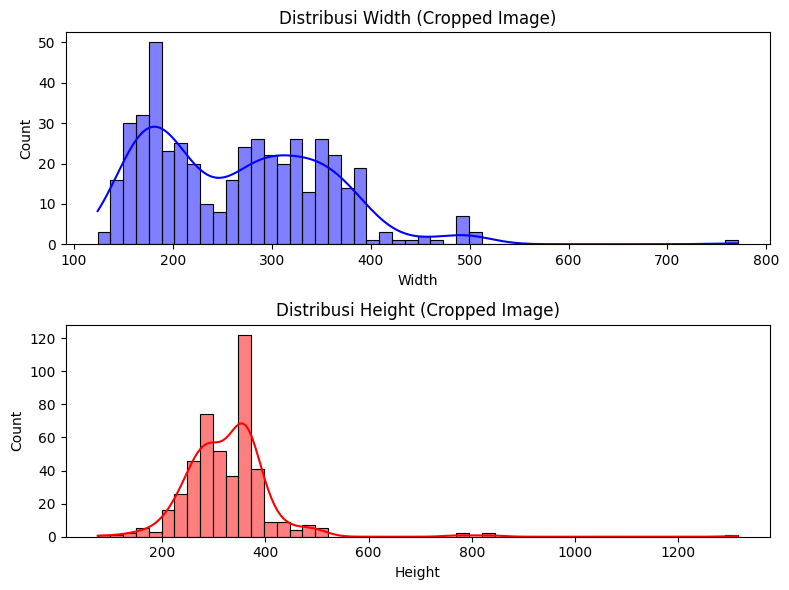

In [ ]:
plt.figure(figsize=(8, 6))  # Lebarkan figure agar lebih jelas

# Histogram untuk Width (image_size_df)
plt.subplot(2, 1, 1)
sns.histplot(image_size_df['Width'], bins=50, kde=True, color='blue')
plt.xlabel("Width")
plt.ylabel("Count")
plt.title("Distribusi Width (Cropped Image)")

# Histogram untuk Height (image_size_df)
plt.subplot(2, 1, 2)
sns.histplot(image_size_df['Height'], bins=50, kde=True, color='red')
plt.xlabel("Height")
plt.ylabel("Count")
plt.title("Distribusi Height (Cropped Image)")

plt.tight_layout()
plt.show()


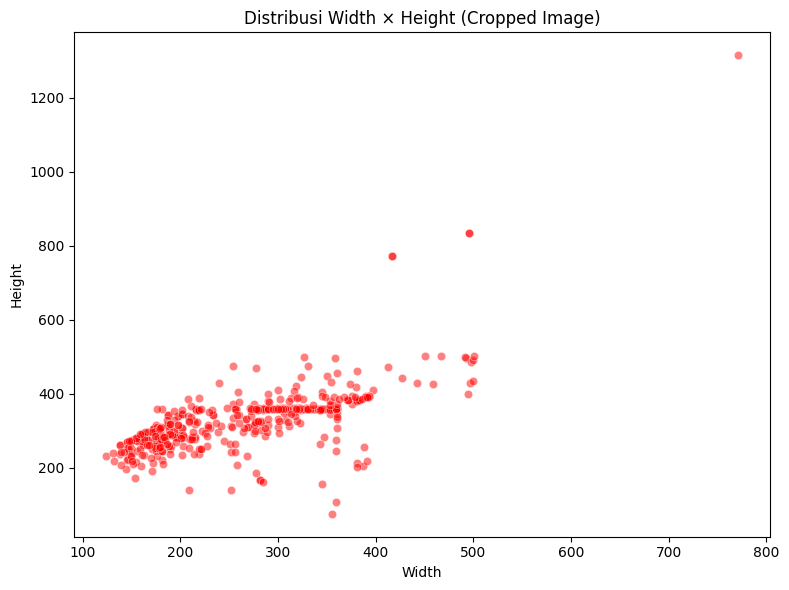

In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=image_size_df['Width'], y=image_size_df['Height'], alpha=0.5, color='red')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribusi Width × Height (Cropped Image)")

plt.tight_layout()
plt.show()


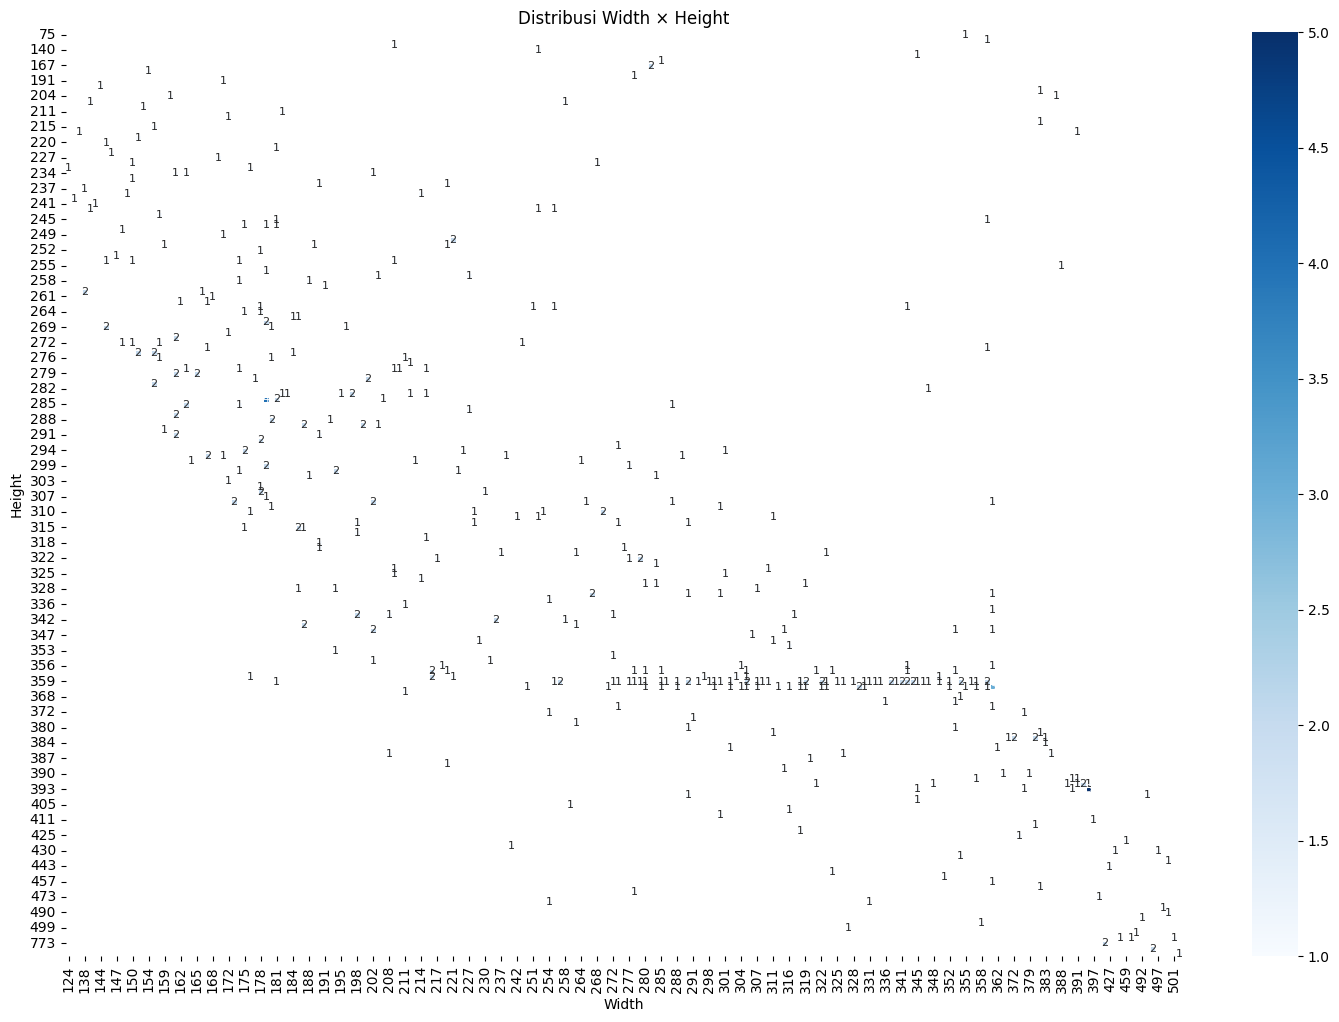

In [ ]:
# Hitung jumlah kemunculan setiap pasangan (width, height)
size_counts = image_size_df.groupby(['Width', 'Height']).size().reset_index(name='count')

# Pivot tabel agar cocok untuk heatmap
size_pivot = size_counts.pivot(index='Height', columns='Width', values='count')

plt.figure(figsize=(18, 12))
sns.heatmap(size_pivot, cmap="Blues", linewidths=0.5, annot=True, annot_kws={"size": 8}, fmt=".0f")

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribusi Width × Height")
plt.show()

### Klinis

1. statistic deskriptif
2. distribusi feature
3. outlier
4. null
5. heatmap

In [ ]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 342 non-null    float64
 1   foto_cairan        342 non-null    object 
 2   durasi_masuk       342 non-null    float64
 3   foto_cairan_url    342 non-null    object 
 4   volume_masuk       342 non-null    float64
 5   volume_keluar      342 non-null    float64
 6   waktu_masuk        342 non-null    object 
 7   waktu_keluar       342 non-null    object 
 8   berat_badan        342 non-null    float64
 9   tekanan_darah_mm   342 non-null    float64
 10  tekanan_darah_hg   342 non-null    float64
 11  nadi               342 non-null    float64
 12  waktu_penggantian  342 non-null    object 
 13  volume             342 non-null    float64
 14  jenis_kelamin      342 non-null    object 
 15  kondisi            342 non-null    object 
dtypes: float64(9), object(7)
m

In [ ]:
abnormal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 41 non-null     float64
 1   foto_cairan        41 non-null     object 
 2   durasi_masuk       41 non-null     float64
 3   foto_cairan_url    41 non-null     object 
 4   volume_masuk       41 non-null     float64
 5   volume_keluar      41 non-null     float64
 6   waktu_masuk        41 non-null     object 
 7   waktu_keluar       41 non-null     object 
 8   berat_badan        41 non-null     float64
 9   tekanan_darah_mm   41 non-null     float64
 10  tekanan_darah_hg   41 non-null     float64
 11  nadi               41 non-null     float64
 12  waktu_penggantian  41 non-null     object 
 13  volume             41 non-null     float64
 14  jenis_kelamin      41 non-null     object 
 15  kondisi            41 non-null     object 
dtypes: float64(9), object(7)
mem

In [ ]:
normal_df.describe()

,id,durasi_masuk,volume_masuk,volume_keluar,berat_badan,tekanan_darah_mm,tekanan_darah_hg,nadi,volume
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,3632.883041,12.523392,1661.570175,1884.947368,65.094327,134.596491,82.377193,78.380117,1604.385965
std,1573.130684,5.857374,442.445960,496.394452,12.466349,20.633822,10.759480,14.881604,470.051538
min,1424.000000,1.000000,1.000000,1.000000,45.000000,83.000000,58.000000,57.000000,200.000000
25%,2398.250000,10.000000,1500.000000,1600.000000,51.000000,124.000000,76.000000,67.000000,1500.000000
50%,3160.500000,10.000000,1800.000000,2000.000000,61.000000,133.000000,83.000000,75.000000,1500.000000
75%,4893.750000,15.000000,2000.000000,2200.000000,78.600000,144.000000,88.750000,92.000000,2000.000000
max,7550.000000,40.000000,2000.000000,3000.000000,84.000000,200.000000,120.000000,114.000000,2000.000000


In [ ]:
abnormal_df.describe()

,id,durasi_masuk,volume_masuk,volume_keluar,berat_badan,tekanan_darah_mm,tekanan_darah_hg,nadi,volume
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,3077.609756,5.707317,1063.414634,1237.926829,62.490976,156.682927,94.682927,69.146341,1136.585366
std,760.040686,2.182245,304.759001,398.937614,9.957671,15.824726,6.186433,13.587790,250.754958
min,1613.000000,5.000000,500.000000,200.000000,47.350000,122.000000,80.000000,57.000000,800.000000
25%,2318.000000,5.000000,1000.000000,1050.000000,48.580000,143.000000,90.000000,58.000000,1000.000000
50%,3251.000000,5.000000,1000.000000,1150.000000,68.000000,161.000000,95.000000,67.000000,1000.000000
75%,3469.000000,5.000000,1000.000000,1350.000000,68.000000,168.000000,99.000000,79.000000,1300.000000
max,5910.000000,15.000000,2000.000000,2200.000000,80.000000,178.000000,105.000000,103.000000,2000.000000


In [ ]:
merged_df = pd.concat([normal_df, abnormal_df], ignore_index=True)
merged_df

,id,foto_cairan,durasi_masuk,foto_cairan_url,volume_masuk,volume_keluar,waktu_masuk,waktu_keluar,berat_badan,tekanan_darah_mm,tekanan_darah_hg,nadi,waktu_penggantian,volume,jenis_kelamin,kondisi
0,1424.0,de6f8f42c8628f05c07acbf6caad7d33,15.0,https://storage-api.its.ac.id/public/220024688...,1500.0,1800.0,2025-04-24 05:45:00,2025-04-24 11:00:00,52.0,134.0,85.0,67.0,2025-04-24 05:30:00,1500.0,L,normal
1,1574.0,2584a92e69b013df51e97e823e927ae8,15.0,https://storage-api.its.ac.id/public/220024688...,1500.0,1600.0,2025-04-24 11:15:00,2025-04-24 17:00:00,51.0,136.0,96.0,65.0,2025-04-24 11:00:00,1500.0,L,normal
2,1575.0,5f6c91d5f58bc9b32719cf8c7c50fcfd,15.0,https://storage-api.its.ac.id/public/220024688...,1500.0,1500.0,2025-04-24 17:15:00,2025-04-24 21:30:00,51.0,136.0,96.0,65.0,2025-04-24 17:00:00,1500.0,L,normal
3,1576.0,5b6d5e274e6787b835334936902ec63e,15.0,https://storage-api.its.ac.id/public/220024688...,1500.0,1650.0,2025-04-24 21:45:00,2025-04-24 05:30:00,51.0,136.0,96.0,65.0,2025-04-24 22:00:00,1500.0,L,normal
4,1540.0,a42e2f6fbb07979c3663001d8cdeb491,15.0,https://storage-api.its.ac.id/public/220024688...,1500.0,1900.0,2025-04-24 21:15:00,2025-04-24 05:45:00,51.0,130.0,90.0,70.0,2025-04-24 22:00:00,1500.0,L,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,3664.0,912ff63fec7b79d6dd180de8f6ef79bc,5.0,https://storage-api.its.ac.id/public/220024688...,1000.0,1000.0,2025-04-24 04:50:00,2025-04-24 10:19:00,69.0,168.0,105.0,68.0,2025-04-24 04:00:00,1000.0,L,normal
379,3677.0,b5ce42e1186b1f35e3bd44ca20120bba,5.0,https://storage-api.its.ac.id/public/220024688...,1000.0,1150.0,2025-04-24 10:25:00,2025-04-24 16:00:00,69.0,168.0,105.0,68.0,2025-04-24 10:00:00,1000.0,L,normal
380,3682.0,85fa15d15bf33bbba659b951e9c9a942,5.0,https://storage-api.its.ac.id/public/220024688...,1000.0,1200.0,2025-04-24 16:13:00,2025-04-24 21:17:00,69.0,168.0,105.0,68.0,2025-04-24 16:00:00,1000.0,L,normal
381,3686.0,341859d537d156d9ca1df1528da79c24,5.0,https://storage-api.its.ac.id/public/220024688...,1000.0,1100.0,2025-04-24 21:30:00,2025-04-24 04:15:00,69.0,168.0,105.0,68.0,2025-04-24 22:00:00,1000.0,L,normal


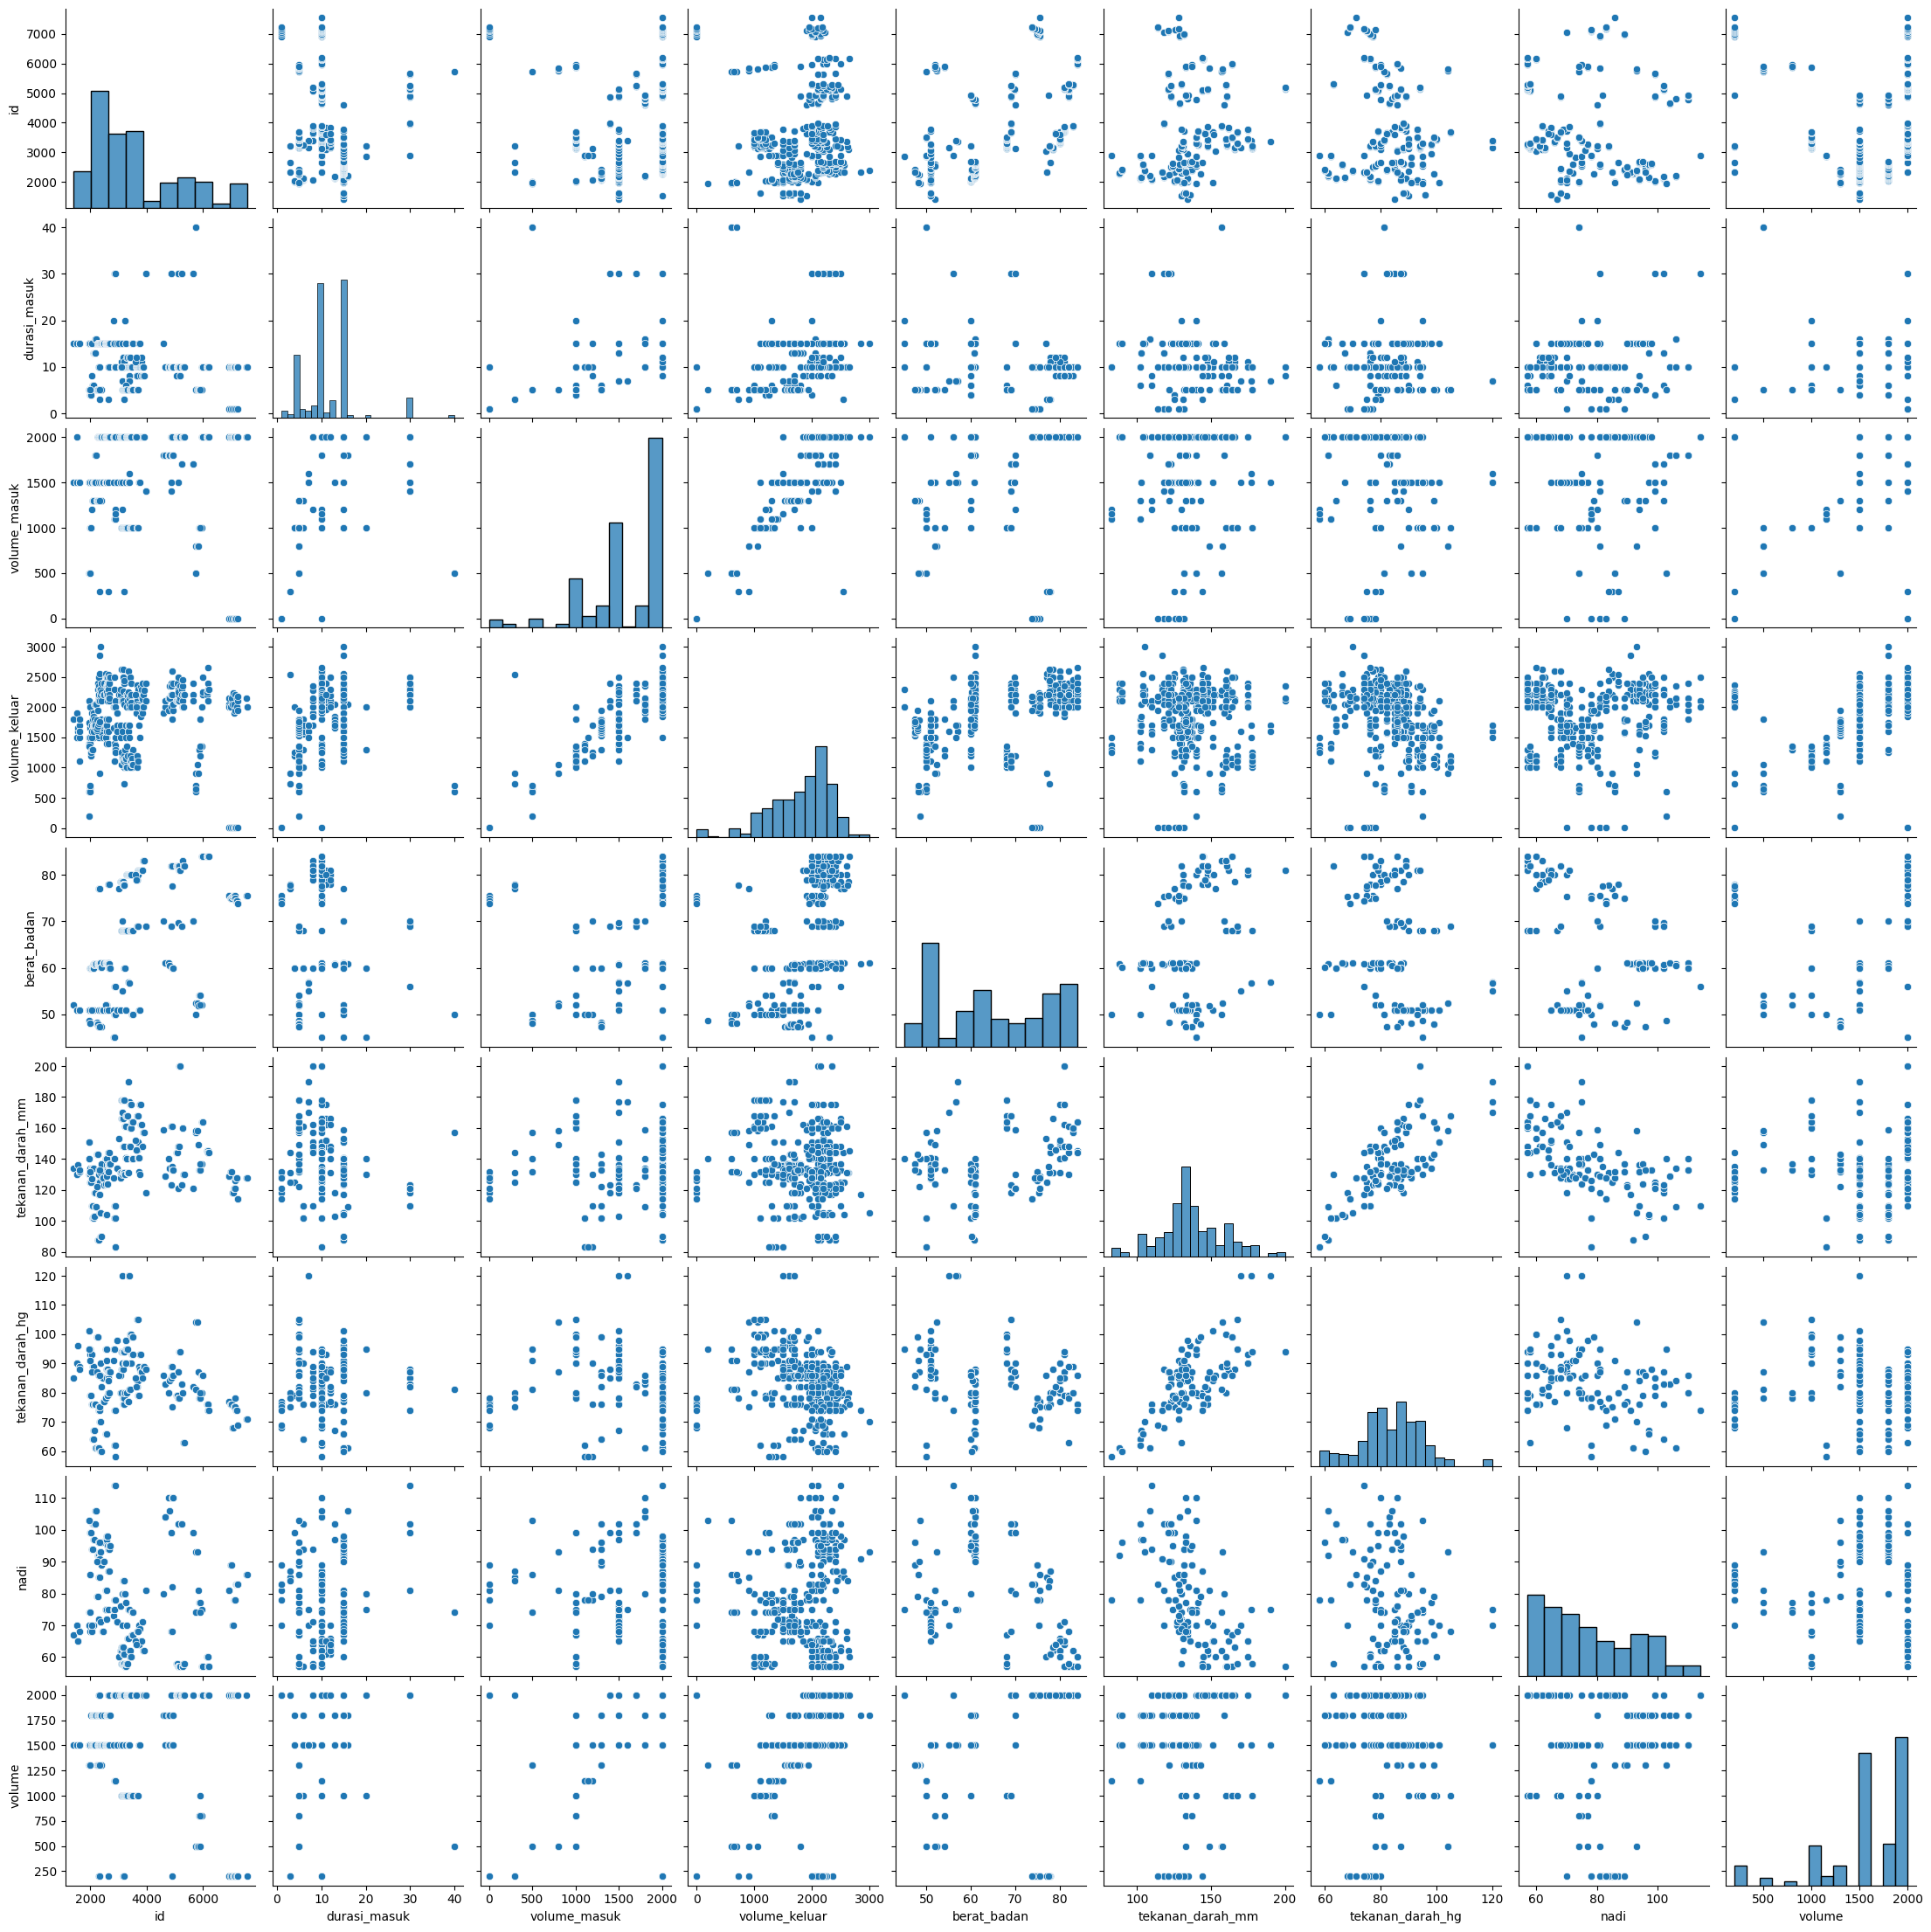

In [ ]:
sns.pairplot(merged_df)
plt.show()

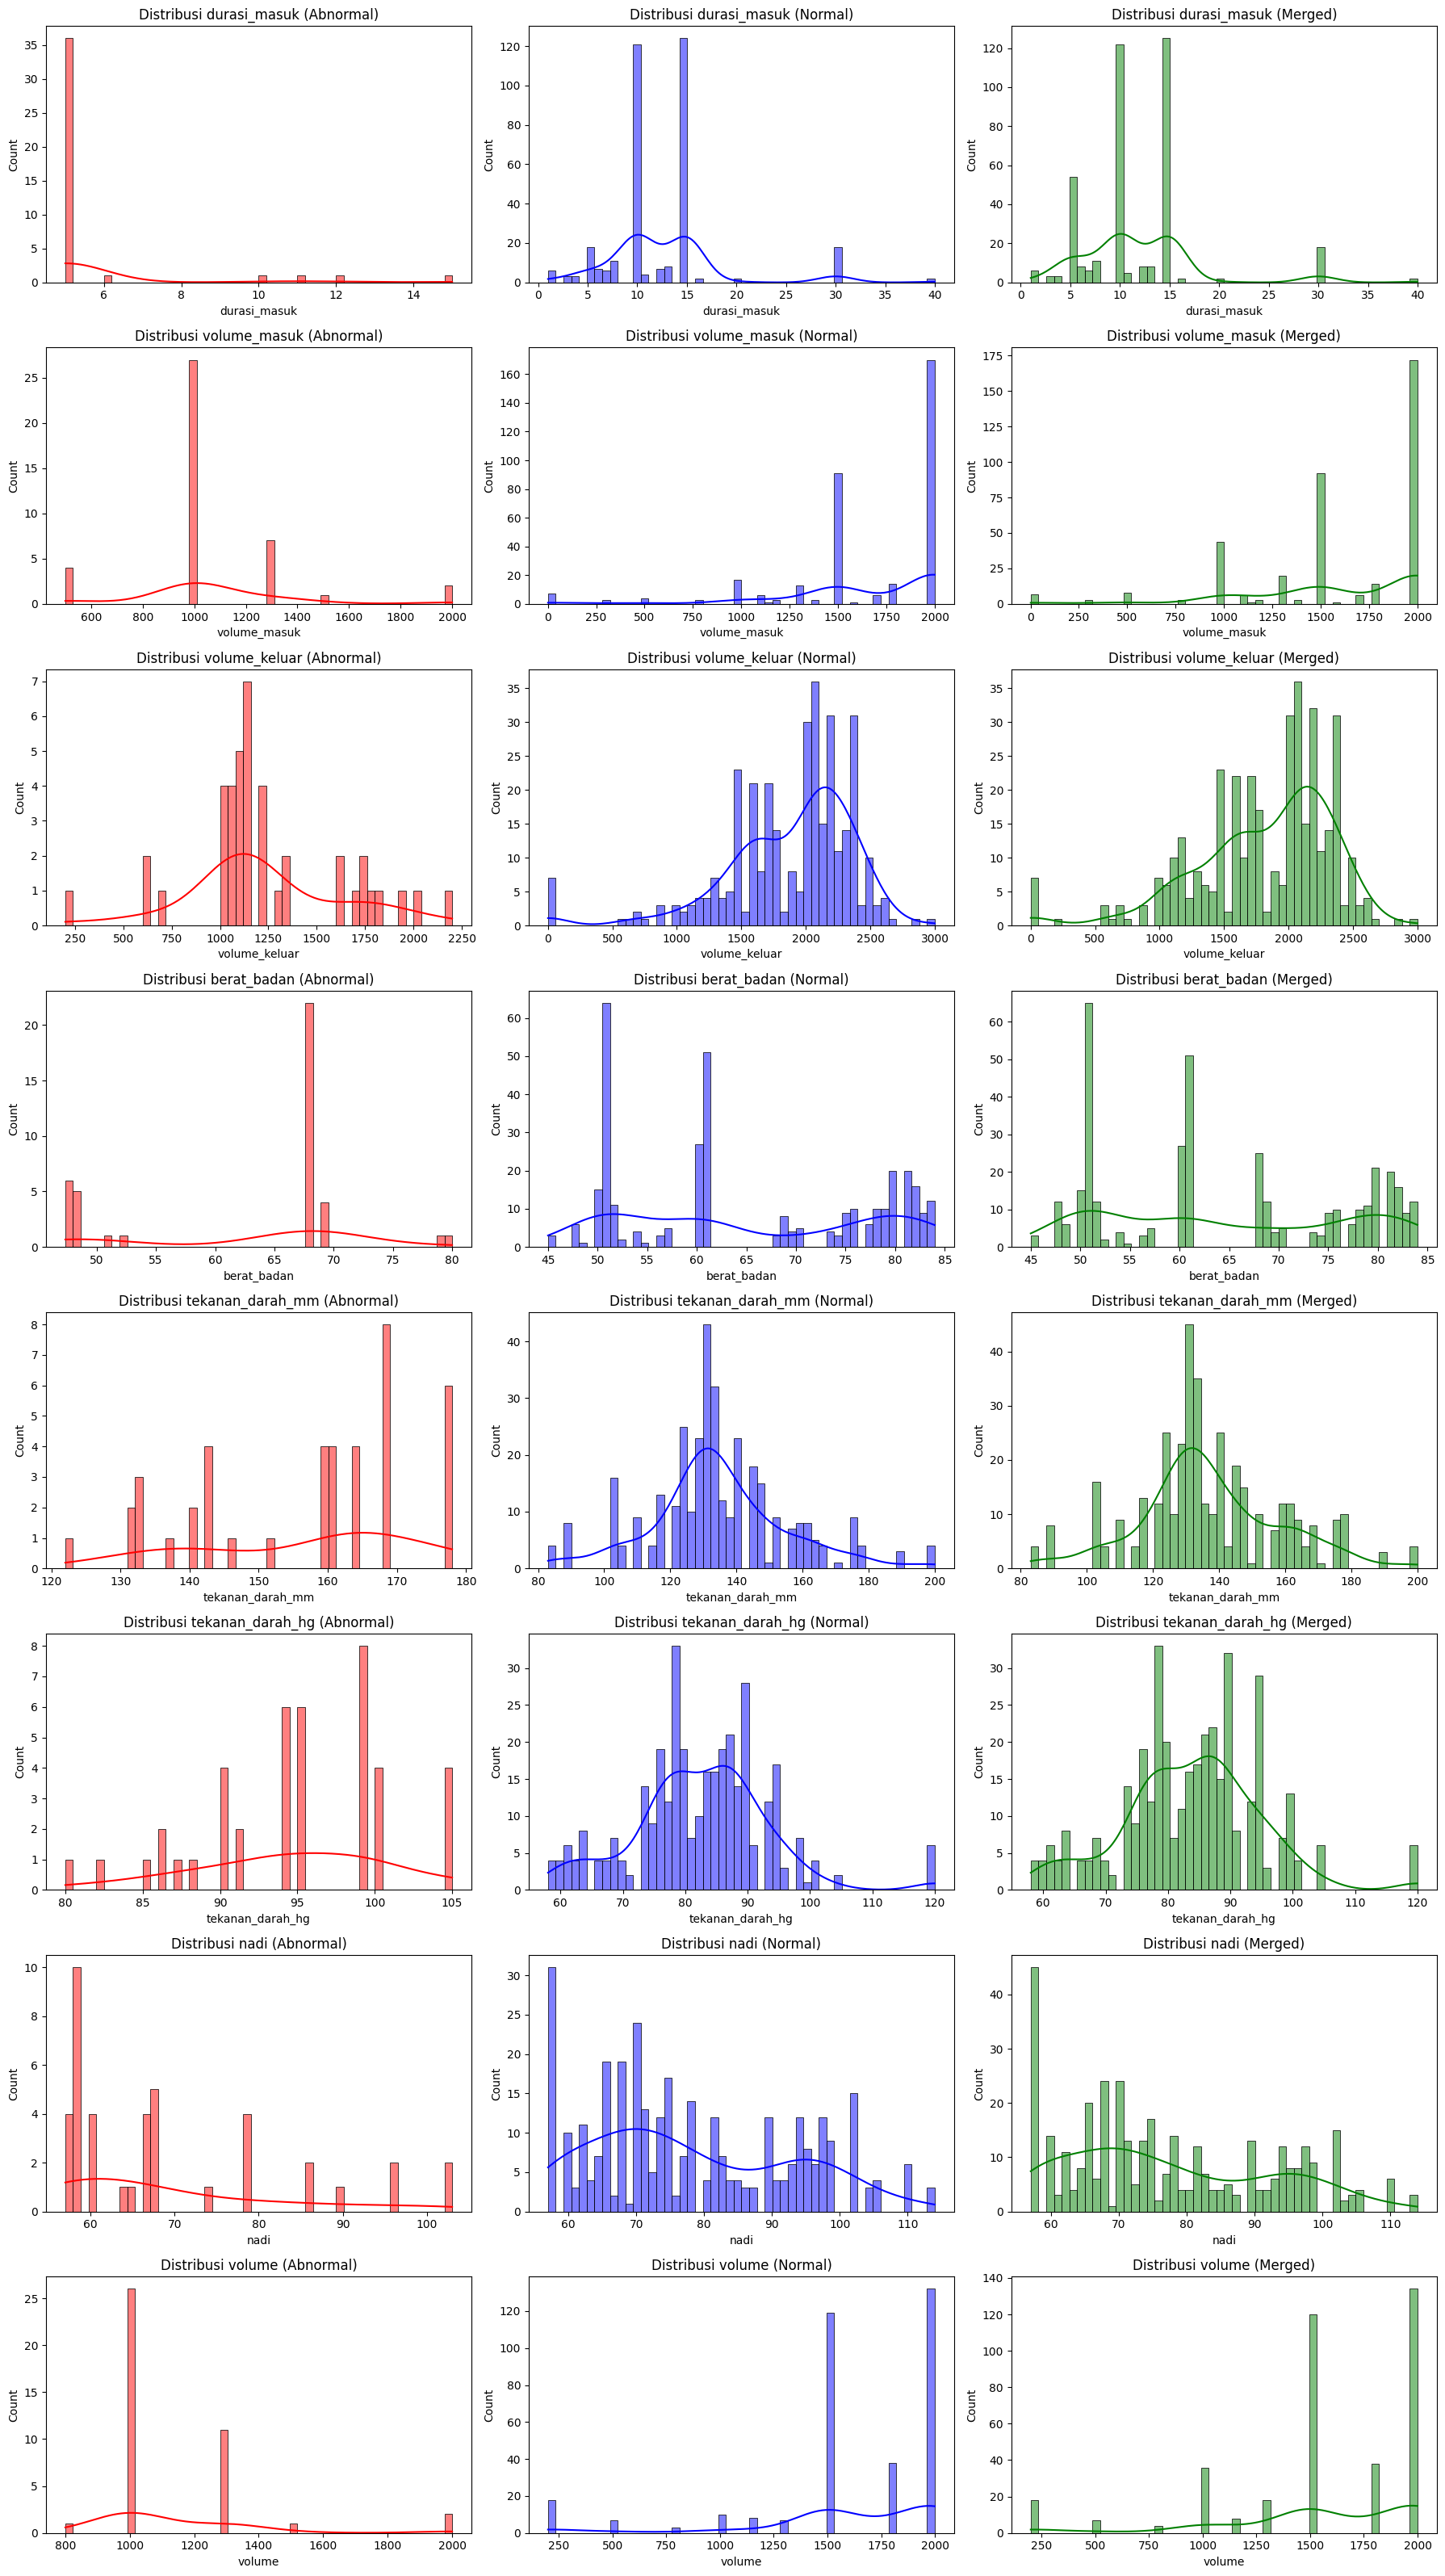

In [ ]:
columns = ["durasi_masuk", "volume_masuk", "volume_keluar", "berat_badan", "tekanan_darah_mm", "tekanan_darah_hg", "nadi", "volume"]

# Setup subplot: 1 baris per kolom, 3 kolom untuk abnormal, normal, merged
fig, axes = plt.subplots(nrows=len(columns), ncols=3, figsize=(18, len(columns) * 4))

# Kalau axes 2D, pastikan indexingnya konsisten
for i, col in enumerate(columns):
    # Plot dataset abnormal
    sns.histplot(x=col, data=abnormal_df, bins=50, kde=True, color='red', ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribusi {col} (Abnormal)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # Plot dataset normal
    sns.histplot(x=col, data=normal_df, bins=50, kde=True, color='blue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribusi {col} (Normal)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')

    # Plot dataset merged
    sns.histplot(x=col, data=merged_df, bins=50, kde=True, color='green', ax=axes[i, 2])
    axes[i, 2].set_title(f'Distribusi {col} (Merged)')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel('Count')

# Menyesuaikan layout agar rapi
plt.tight_layout()
plt.show()

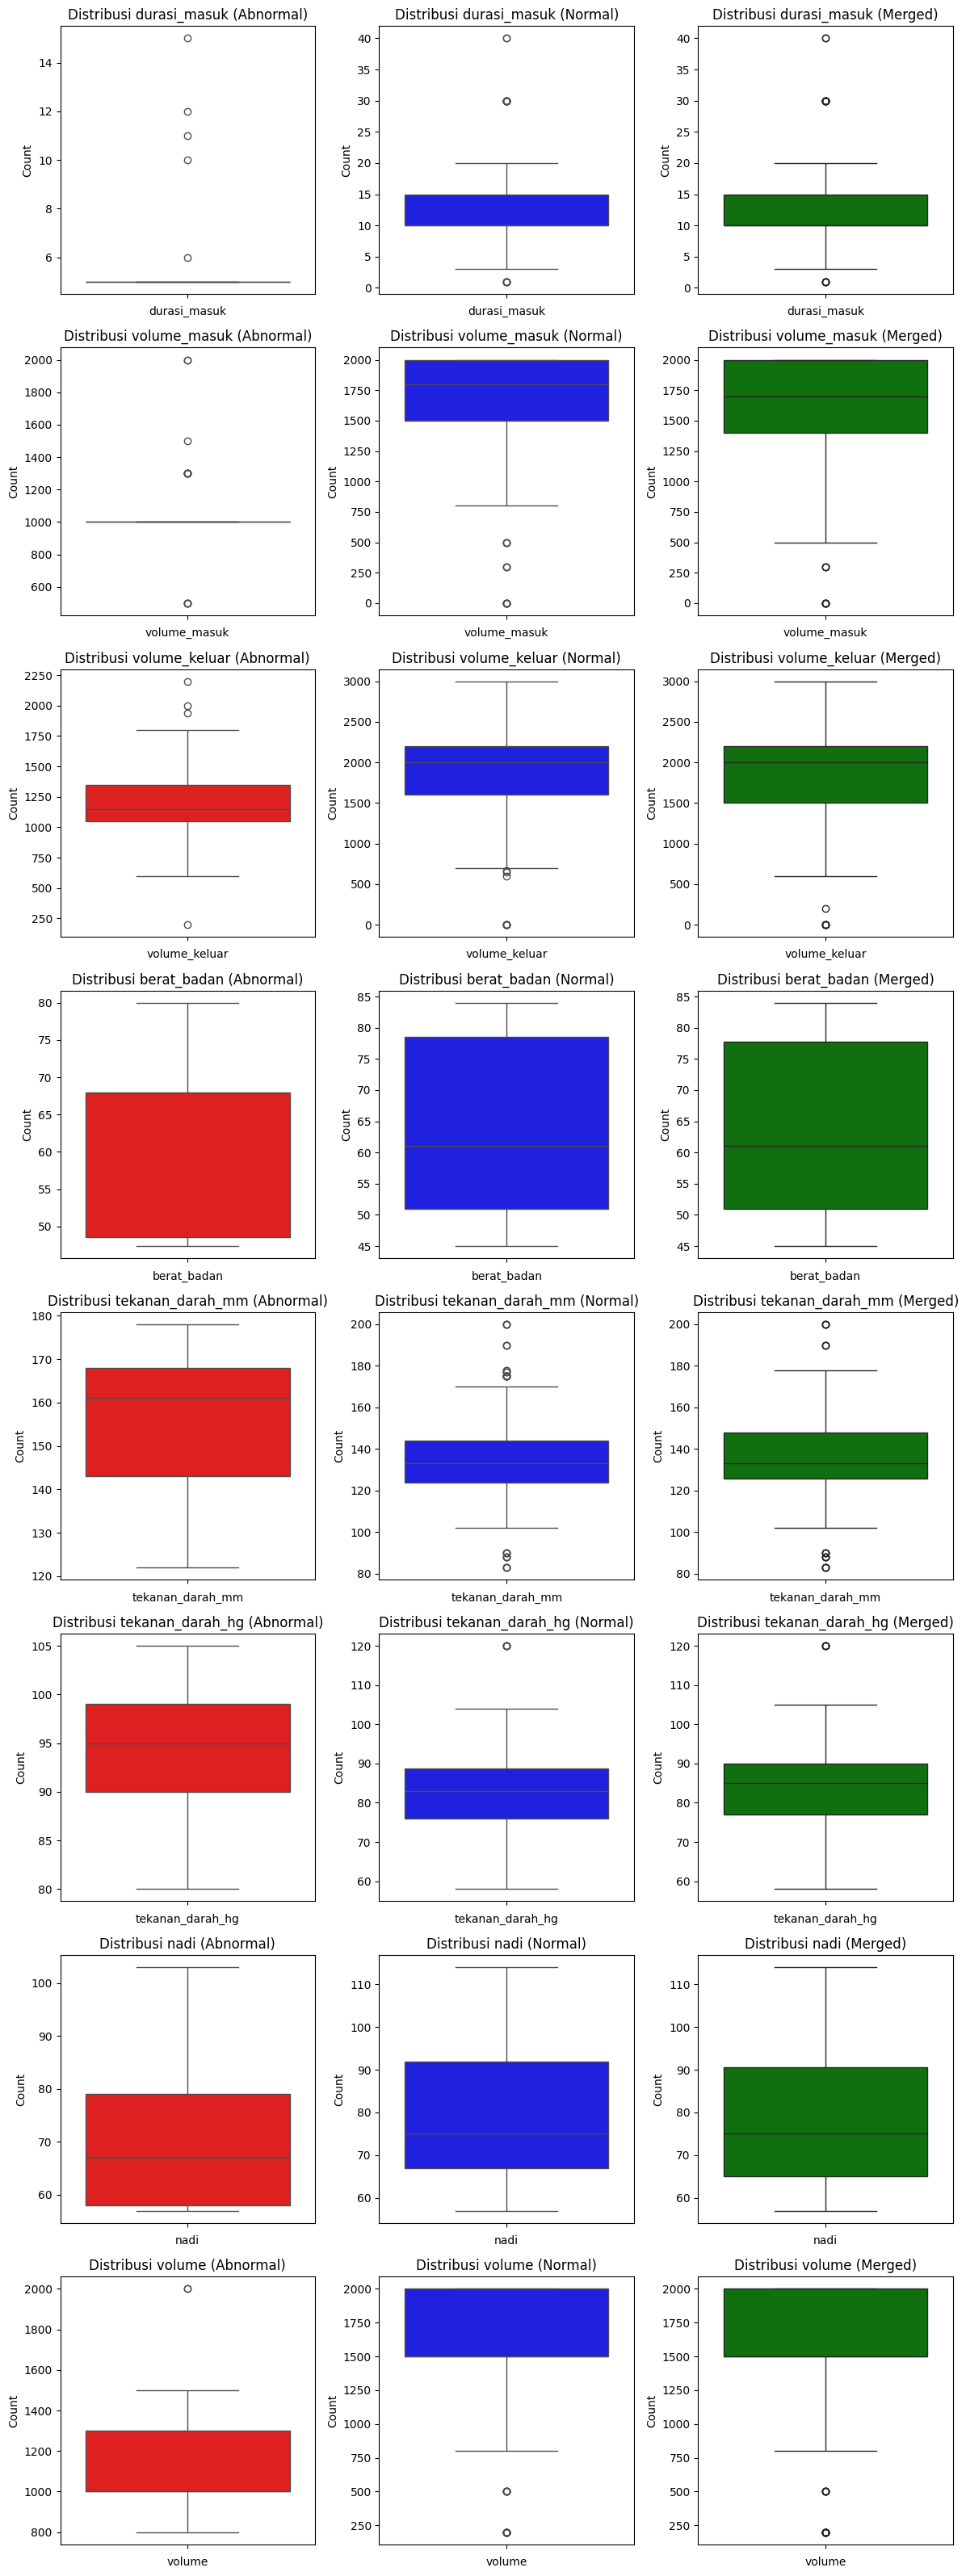

In [ ]:
columns = ["durasi_masuk", "volume_masuk", "volume_keluar", "berat_badan", "tekanan_darah_mm", "tekanan_darah_hg", "nadi", "volume"]

# Setup subplot: 2 kolom, jumlah baris menyesuaikan jumlah kolom (4 variabel, jadi 2x4 = 8 subplot)
fig, axes = plt.subplots(nrows=len(columns), ncols=3, figsize=(12, len(columns) * 4))

# Loop setiap kolom untuk Normal dan Abnormal dataset
for i, col in enumerate(columns):
    # Plot untuk dataset abnormal
    sns.boxplot(y=abnormal_df[col], color='red', ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribusi {col} (Abnormal)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # Plot untuk dataset normal
    sns.boxplot(y=normal_df[col], color='blue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribusi {col} (Normal)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')

    # Plot untuk dataset merged
    sns.boxplot(y=merged_df[col], color='green', ax=axes[i, 2])
    axes[i, 2].set_title(f'Distribusi {col} (Merged)')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel('Count')

# Menyesuaikan layout supaya tidak bertumpuk
plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Tentukan batas bawah dan atas untuk outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Temukan baris yang mengandung outlier
    outlier_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outlier_rows

In [ ]:
columns = ["durasi_masuk", "volume_masuk", "volume_keluar", "berat_badan",
           "tekanan_darah_mm", "tekanan_darah_hg", "nadi", "volume"]

outlier_normal_summary = []
outlier_abnormal_summary = []

for col in columns:
    # Outliers untuk normal
    normal_outliers = detect_outliers(normal_df, col)
    if isinstance(normal_outliers, pd.DataFrame):
        normal_outliers_index = normal_outliers.index
    else:
        normal_outliers_index = normal_outliers  # misal sudah index

    outlier_normal_summary.append({
        "feature": col,
        "n_outliers": len(normal_outliers_index),
        "outlier_values": normal_df.loc[normal_outliers_index, col].tolist()
    })

    # Outliers untuk abnormal
    abnormal_outliers = detect_outliers(abnormal_df, col)
    if isinstance(abnormal_outliers, pd.DataFrame):
        abnormal_outliers_index = abnormal_outliers.index
    else:
        abnormal_outliers_index = abnormal_outliers

    outlier_abnormal_summary.append({
        "feature": col,
        "n_outliers": len(abnormal_outliers_index),
        "outlier_values": abnormal_df.loc[abnormal_outliers_index, col].tolist()
    })

# Buat dua DataFrame terpisah
outliers_normal_df = pd.DataFrame(outlier_normal_summary)
outliers_abnormal_df = pd.DataFrame(outlier_abnormal_summary)

In [ ]:
outliers_normal_df

,feature,n_outliers,outlier_values
0,durasi_masuk,26,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30...."
1,volume_masuk,14,"[500.0, 300.0, 300.0, 300.0, 500.0, 500.0, 500..."
2,volume_keluar,10,"[665.0, 600.0, 650.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,berat_badan,0,[]
4,tekanan_darah_mm,32,"[88.0, 88.0, 88.0, 88.0, 90.0, 90.0, 90.0, 90...."
5,tekanan_darah_hg,6,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0]"
6,nadi,0,[]
7,volume,25,"[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 500..."


In [ ]:
outliers_abnormal_df

,feature,n_outliers,outlier_values
0,durasi_masuk,5,"[15.0, 10.0, 6.0, 11.0, 12.0]"
1,volume_masuk,14,"[1300.0, 1500.0, 500.0, 500.0, 500.0, 500.0, 1..."
2,volume_keluar,4,"[200.0, 1940.0, 2200.0, 2000.0]"
3,berat_badan,0,[]
4,tekanan_darah_mm,0,[]
5,tekanan_darah_hg,0,[]
6,nadi,0,[]
7,volume,2,"[2000.0, 2000.0]"


In [ ]:
outliers_abnormal_df

,feature,n_outliers,outlier_values
0,durasi_masuk,5,"[15.0, 10.0, 6.0, 11.0, 12.0]"
1,volume_masuk,14,"[1300.0, 1500.0, 500.0, 500.0, 500.0, 500.0, 1..."
2,volume_keluar,4,"[200.0, 1940.0, 2200.0, 2000.0]"
3,berat_badan,0,[]
4,tekanan_darah_mm,0,[]
5,tekanan_darah_hg,0,[]
6,nadi,0,[]
7,volume,2,"[2000.0, 2000.0]"


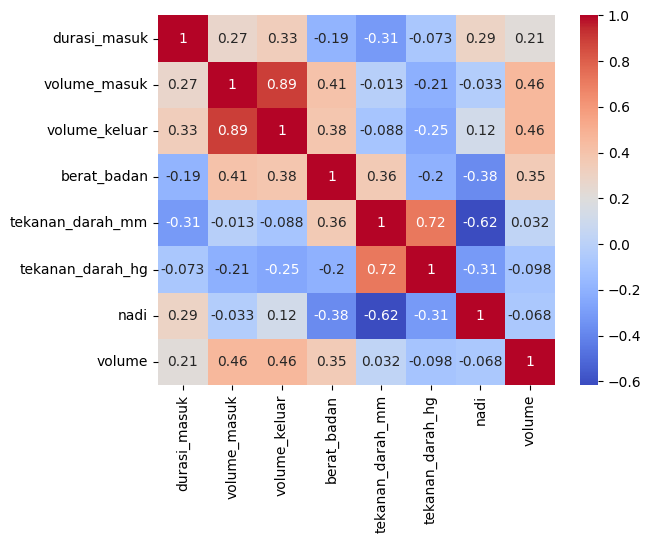

In [ ]:
sns.heatmap(merged_df[columns].corr(), annot=True, cmap='coolwarm')
plt.show()

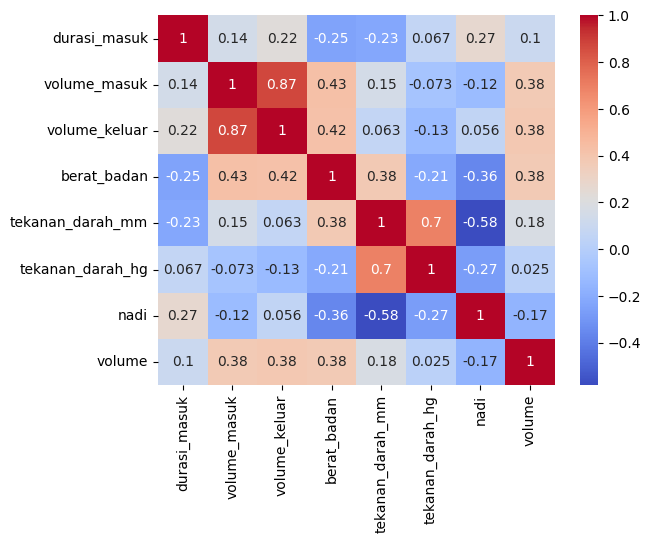

In [ ]:
sns.heatmap(normal_df[columns].corr(), annot=True, cmap='coolwarm')
plt.show()

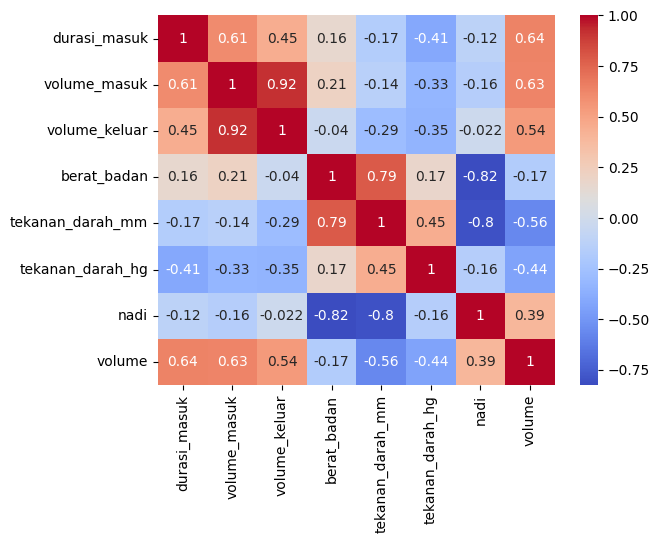

In [ ]:
sns.heatmap(abnormal_df[columns].corr(), annot=True, cmap='coolwarm')
plt.show()

## Data Preprocessing

### Images

1. resize image
2. feature extraction

#### Load Pretrained Model

In [ ]:
# Load Swin Transformer
swin = models.swin_v2_s(pretrained=True).to(device)
for param in swin.parameters():
    param.requires_grad = False
swin.head = torch.nn.Identity()  # Ambil fitur sebelum classifier

# Load CaiT
cait = timm.create_model("cait_s24_224", pretrained=True).to(device)
for param in cait.parameters():
    param.requires_grad = False
cait.head = torch.nn.Identity()

# Load CoAtNet
coatnet = timm.create_model("coatnet_0_rw_224.sw_in1k", pretrained=True).to(device)
for param in coatnet.parameters():
    param.requires_grad = False
coatnet.head = torch.nn.Identity()

# Load YOLOv9
yolov9 = YOLO("yolov9c.pt")
for param in yolov9.parameters():
    param.requires_grad = False

models_dict = {
    "swin": (swin, (224, 224)),
    "cait": (cait, (224, 224)),  # Ubah ke (384, 384) jika mau yang lebih besar
    "coatnet": (coatnet, (224, 224)),
    "yolov9": (yolov9, (640, 640))
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:01<00:00, 177MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

100%|██████████| 49.4M/49.4M [00:01<00:00, 46.3MB/s]


#### Early Image augmentation for abnormal data

In [ ]:
abnormal_img_path = '/content/drive/MyDrive/dataset/images/images_v2/cropped/abnormal'
output_dir = '/content/drive/MyDrive/dataset/images/images_v2/cropped_augmentation/'

In [ ]:
import os
from PIL import Image
import torchvision.transforms as T
from natsort import natsorted

# Path input dan output
input_dir = '/content/drive/MyDrive/dataset/images/images_v2/cropped/abnormal'
output_dir = '/content/drive/MyDrive/dataset/images/images_v2/temp/'
os.makedirs(output_dir, exist_ok=True)

# Ambil dan urutkan file gambar secara natural
image_files = natsorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Cari nomor terakhir dari gambar real
real_numbers = [int(f.split('_')[1].split('.')[0]) for f in image_files if 'abnormal_' in f]
start_index = max(real_numbers) + 1 if real_numbers else 1

# Augmentasi: flip vertikal dan perubahan kecerahan/kontras
augmentations = [
    T.RandomVerticalFlip(p=1.0)
]

# Lakukan augmentasi
counter = start_index + 40
for img_file in image_files:
    img_path = os.path.join(input_dir, img_file)
    img = Image.open(img_path).convert('RGB')

    for aug in augmentations:
        augmented_img = aug(img)
        save_path = os.path.join(output_dir, f"abnormal-{counter}.jpg")
        augmented_img.save(save_path)
        counter += 1

print(f"Augmentasi selesai. Total gambar augmentasi ditambahkan: {counter - start_index-40}")


Augmentasi selesai. Total gambar augmentasi ditambahkan: 41


#### Transform and Load Images

In [ ]:
abnormal_img_path = '/content/drive/MyDrive/dataset/images/images_v2/cropped/abnormal'
normal_img_path = '/content/drive/MyDrive/dataset/images/images_v2/cropped/normal'

In [ ]:
image_paths = []
labels = []

for fname in os.listdir(normal_img_path):
    if fname.lower().endswith(('.jpg', '.png')):
        image_paths.append(os.path.join(normal_img_path, fname))
        labels.append(0)

for fname in os.listdir(abnormal_img_path):
    if fname.lower().endswith(('.jpg', '.png')):
        image_paths.append(os.path.join(abnormal_img_path, fname))
        labels.append(1)

In [ ]:
class CombinedImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Transformasi sesuai ukuran tiap model
transform_dict = {
    "swin": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "cait": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "coatnet": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "yolov9": transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}

batch_size = 16

dataloaders = {}

for model_name, transform in transform_dict.items():
    # Bikin dataset gabungan pakai transform yang sesuai
    combined_dataset = CombinedImageDataset(image_paths, labels, transform=transform)

    # Masukin ke DataLoader
    dataloaders[f"{model_name}_cropped"] = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=False
    )

#### Feature Extraction

In [ ]:
def extract_features(model, dataloader, device, model_name):
    features = []
    all_labels = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            all_labels.extend(labels.numpy())  # simpan labelnya

            if model_name == "yolov9":
                backbone = model.model.model[:10]
                backbone_output = backbone(images)
                output = backbone_output[-1] if isinstance(backbone_output, (list, tuple)) else backbone_output
            else:
                output = model(images)

            if isinstance(output, (list, tuple)):
                output = output[0]

            if output.dim() > 2:
                output = output.reshape(output.size(0), -1)

            features.append(output.cpu().numpy())

    return np.concatenate(features, axis=0), np.array(all_labels)


In [ ]:
features_dict = {}

for model_name, (model, _) in models_dict.items():
    for image_type in ["cropped"]:
        key = f"{model_name}_{image_type}"
        print(f"Ekstrak fitur dari {key}...")

        features, labels = extract_features(model, dataloaders[key], device, model_name)
        features_dict[key] = {"features": features, "labels": labels}

# Simpan ke .npy
for key, data in features_dict.items():
    np.save(f"{key}_features.npy", data["features"])
    np.save(f"{key}_labels.npy", data["labels"])

print("Feature extraction selesai! 🚀")

Ekstrak fitur dari swin_cropped...
Ekstrak fitur dari cait_cropped...
Ekstrak fitur dari coatnet_cropped...
Ekstrak fitur dari yolov9_cropped...
Feature extraction selesai! 🚀


In [ ]:
# Path ke folder tujuan di Google Drive
drive_folder = "/content/drive/MyDrive/dataset/feature-extracted-v4"

# Buat folder jika belum ada
os.makedirs(drive_folder, exist_ok=True)

# Simpan fitur dan label ke file CSV di Drive
for key, data in features_dict.items():
    df = pd.DataFrame(data["features"])
    df['label'] = data["labels"]

    output_path = os.path.join(drive_folder, f"{key}_features.csv")
    df.to_csv(output_path, index=False)

print(f"Semua fitur disimpan ke: {drive_folder} ✅")


Semua fitur disimpan ke: /content/drive/MyDrive/dataset/feature-extracted-v4 ✅


In [ ]:
features_dict.keys()

dict_keys(['swin_cropped', 'cait_cropped', 'coatnet_cropped', 'yolov9_cropped'])

In [ ]:
features_dict["swin_cropped"]

{'features': array([[   -0.50603,    -0.30685,      0.2112, ...,    -0.15977,     -0.0408,    -0.61441],
        [   0.064806,    -0.37047,     -0.1392, ...,     0.31319,     0.10874,    -0.30264],
        [   -0.45724,    0.038379,     0.28735, ...,    -0.11277,     -0.1749,    -0.38002],
        ...,
        [    0.48427,   -0.070585,    -0.19653, ...,   -0.090582,     0.19306,    -0.18614],
        [    0.65594,    0.090839,    -0.20494, ...,     0.12699,     0.26644,    -0.18301],
        [ -0.0094642,    0.014297,    -0.48879, ...,   -0.093102,    -0.06689,    -0.69249]], dtype=float32),
 'labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
features_dict["swin_cropped"]['features'].shape

(465, 768)

In [ ]:
features_dict["cait_cropped"]['features'].shape

(465, 384)

In [ ]:
features_dict["coatnet_cropped"]['features'].shape

(465, 37632)

In [ ]:
features_dict["yolov9_cropped"]['features'].shape

(465, 204800)

In [ ]:
features_dict["swin_cropped"]['features']

array([[   -0.50603,    -0.30685,      0.2112, ...,    -0.15977,     -0.0408,    -0.61441],
       [   0.064806,    -0.37047,     -0.1392, ...,     0.31319,     0.10874,    -0.30264],
       [   -0.45724,    0.038379,     0.28735, ...,    -0.11277,     -0.1749,    -0.38002],
       ...,
       [    0.48427,   -0.070585,    -0.19653, ...,   -0.090582,     0.19306,    -0.18614],
       [    0.65594,    0.090839,    -0.20494, ...,     0.12699,     0.26644,    -0.18301],
       [ -0.0094642,    0.014297,    -0.48879, ...,   -0.093102,    -0.06689,    -0.69249]], dtype=float32)

In [ ]:
features_dict["cait_cropped"]['features']

array([[     1.0448,    -0.02902,     0.39461, ...,    0.044203,     -2.0382,     -1.1942],
       [    -1.4013,   -0.046521,     -1.0679, ...,     0.56045,     -5.4218,     -0.6594],
       [    -1.5403,     0.66911,    -0.28215, ...,     0.92943,    0.026227,  0.00082542],
       ...,
       [    0.97377,    -0.34898,   -0.020662, ...,     -1.1182,     -2.2265,       1.057],
       [    -1.0543,    -0.60891,    -0.49294, ...,     0.16553,     -2.1653,    -0.17206],
       [   -0.67094,    -0.59271,     0.26531, ...,     0.96048,     -2.0606,    -0.57842]], dtype=float32)

In [ ]:
features_dict["coatnet_cropped"]['features']

array([[   -0.48096,    -0.44823,    -0.25711, ...,    -0.27873,    0.052054,     0.33772],
       [   -0.40034,      1.8587,     0.63568, ...,     -2.2445,    -0.76647,     -1.5543],
       [   -0.51468,     0.80052,    -0.10912, ...,     0.27236,    -0.24668,     0.36417],
       ...,
       [    0.26467,     0.23242,    0.036517, ...,    -0.15485,   -0.075136,     0.43182],
       [    -0.3506,     -1.1308,      -1.193, ...,    0.032937,     0.10534,      1.8206],
       [    -1.0568,      1.3076,     0.26934, ...,    0.018256,     -2.7251,     0.24782]], dtype=float32)

In [ ]:
features_dict["yolov9_cropped"]['features']

array([[   -0.24044,    -0.19886,    -0.20709, ...,    -0.27722,    -0.25646,    -0.27526],
       [   -0.27846,    -0.27815,    -0.27572, ...,    -0.27337,    -0.27812,    -0.26902],
       [   -0.23103,      -0.044,    0.049259, ...,    -0.12106,    -0.16973,    -0.15111],
       ...,
       [   -0.25857,    -0.23537,    -0.24388, ...,   -0.053266,    -0.08339,    -0.08694],
       [   -0.26748,    -0.25643,    -0.21976, ...,   -0.088982,   -0.083533,     -0.0808],
       [   -0.25405,    -0.27729,    -0.27845, ...,   -0.093878,      -0.121,    -0.10504]], dtype=float32)

### Klinis

1. feature engineering
2. feature selection
3. encoding

output:
- final_normal
- final_abnormal

In [ ]:
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 342 non-null    float64
 1   foto_cairan        342 non-null    object 
 2   durasi_masuk       342 non-null    float64
 3   foto_cairan_url    342 non-null    object 
 4   volume_masuk       342 non-null    float64
 5   volume_keluar      342 non-null    float64
 6   waktu_masuk        342 non-null    object 
 7   waktu_keluar       342 non-null    object 
 8   berat_badan        342 non-null    float64
 9   tekanan_darah_mm   342 non-null    float64
 10  tekanan_darah_hg   342 non-null    float64
 11  nadi               342 non-null    float64
 12  waktu_penggantian  342 non-null    object 
 13  volume             342 non-null    float64
 14  jenis_kelamin      342 non-null    object 
 15  kondisi            342 non-null    object 
dtypes: float64(9), object(7)
m

In [ ]:
col_unused = ['id', 'foto_cairan', 'foto_cairan_url', 'kondisi']
final_normal = normal_df.drop(columns=col_unused)
final_abnormal = abnormal_df.drop(columns=col_unused)

In [ ]:
final_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   durasi_masuk       342 non-null    float64
 1   volume_masuk       342 non-null    float64
 2   volume_keluar      342 non-null    float64
 3   waktu_masuk        342 non-null    object 
 4   waktu_keluar       342 non-null    object 
 5   berat_badan        342 non-null    float64
 6   tekanan_darah_mm   342 non-null    float64
 7   tekanan_darah_hg   342 non-null    float64
 8   nadi               342 non-null    float64
 9   waktu_penggantian  342 non-null    object 
 10  volume             342 non-null    float64
 11  jenis_kelamin      342 non-null    object 
dtypes: float64(8), object(4)
memory usage: 32.2+ KB


In [ ]:
final_normal['volume_masuk'].value_counts()

,count
volume_masuk,
2000.0,170
1500.0,91
1000.0,17
1800.0,14
1300.0,13
1.0,7
1100.0,6
1700.0,6
500.0,4


In [ ]:
final_abnormal['volume_masuk'].value_counts()

,count
volume_masuk,
1000.0,27
1300.0,7
500.0,4
2000.0,2
1500.0,1


In [ ]:
final_normal['volume_masuk'] = final_normal['volume_masuk'].replace(1.0, 1000.0)
final_abnormal['volume_masuk'] = final_abnormal['volume_masuk'].replace(1.0, 1000.0)

In [ ]:
final_normal['volume_masuk'].value_counts()

,count
volume_masuk,
2000.0,170
1500.0,91
1000.0,24
1800.0,14
1300.0,13
1100.0,6
1700.0,6
500.0,4
1200.0,3


In [ ]:
final_normal['volume_keluar'].value_counts().sort_index(ascending=True)

,count
volume_keluar,
1.0,7
600.0,1
650.0,1
665.0,1
700.0,1
...,...
2620.0,1
2630.0,1
2650.0,1


In [ ]:
final_normal['volume_keluar'] = final_normal['volume_keluar'].replace(1.0, 1000.0)
final_abnormal['volume_keluar'] = final_abnormal['volume_keluar'].replace(1.0, 1000.0)

In [ ]:
final_normal['volume_keluar'].value_counts().sort_index(ascending=True)

,count
volume_keluar,
600.0,1
650.0,1
665.0,1
700.0,1
730.0,1
...,...
2620.0,1
2630.0,1
2650.0,1


In [ ]:
final_normal['waktu_keluar'] = pd.to_datetime(final_normal['waktu_keluar'], format='mixed')
final_normal['waktu_masuk'] = pd.to_datetime(final_normal['waktu_masuk'], format='mixed')
final_normal['waktu_penggantian'] = pd.to_datetime(final_normal['waktu_penggantian'], format='mixed')

final_abnormal['waktu_keluar'] = pd.to_datetime(final_abnormal['waktu_keluar'], format='mixed')
final_abnormal['waktu_masuk'] = pd.to_datetime(final_abnormal['waktu_masuk'], format='mixed')
final_abnormal['waktu_penggantian'] = pd.to_datetime(final_abnormal['waktu_penggantian'], format='mixed')

In [ ]:
# Koreksi seluruh baris yang durasinya negatif
mask = final_normal['waktu_keluar'] < final_normal['waktu_masuk']
final_normal.loc[mask, 'waktu_keluar'] += pd.Timedelta(days=1)

mask_abnormal = final_abnormal['waktu_keluar'] < final_abnormal['waktu_masuk']
final_abnormal.loc[mask_abnormal, 'waktu_keluar'] += pd.Timedelta(days=1)

In [ ]:
def tentukan_shift(jam):
    if 5 <= jam < 11:
        return "pagi"
    elif 11 <= jam < 15:
        return "siang"
    elif 15 <= jam < 19:
        return "sore"
    else:
        return "malam"

In [ ]:
final_normal['jam_masuk'] = final_normal['waktu_masuk'].dt.hour
final_normal['hari_masuk'] = final_normal['waktu_masuk'].dt.dayofweek
final_normal['dwell_time_menit'] = (final_normal['waktu_keluar'] - final_normal['waktu_masuk']).dt.total_seconds() / 60
final_normal['jam_keluar'] = final_normal['waktu_keluar'].dt.hour
final_normal['hari_keluar'] = final_normal['waktu_keluar'].dt.dayofweek
final_normal['selisih_volume'] = final_normal['volume_keluar'] - final_normal['volume_masuk']
final_normal["shift_penggantian"] = final_normal["waktu_penggantian"].dt.hour.apply(tentukan_shift)


final_abnormal['jam_masuk'] = final_abnormal['waktu_masuk'].dt.hour
final_abnormal['hari_masuk'] = final_abnormal['waktu_masuk'].dt.dayofweek
final_abnormal['dwell_time_menit'] = (final_abnormal['waktu_keluar'] - final_abnormal['waktu_masuk']).dt.total_seconds() / 60
final_abnormal['jam_keluar'] = final_abnormal['waktu_keluar'].dt.hour
final_abnormal['hari_keluar'] = final_abnormal['waktu_keluar'].dt.dayofweek
final_abnormal['selisih_volume'] = final_abnormal['volume_keluar'] - final_abnormal['volume_masuk']
final_abnormal["shift_penggantian"] = final_abnormal["waktu_penggantian"].dt.hour.apply(tentukan_shift)

In [ ]:
drop_columns = ['waktu_masuk', 'waktu_keluar', 'waktu_penggantian', 'volume']
final_normal = final_normal.drop(columns=drop_columns)
final_abnormal = final_abnormal.drop(columns=drop_columns)

durasi drain = selisih saat proses mengeluarkan cairan yang sudah ada di dalam dengan proses memasukkan cairan yang baru

dwell time = lama cairan berada di dalam

In [ ]:
final_normal = final_normal.rename(columns={'tekanan_darah_mm': 'systolic', 'tekanan_darah_hg': 'diastolic', 'durasi_masuk': 'durasi_drain_menit'})
final_abnormal = final_abnormal.rename(columns={'tekanan_darah_mm': 'systolic', 'tekanan_darah_hg': 'diastolic', 'durasi_masuk': 'durasi_drain_menit'})

In [ ]:
final_normal.head()

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
0,15.0,1500.0,1800.0,52.0,134.0,85.0,67.0,L,5,3,315.0,11,3,300.0,pagi
1,15.0,1500.0,1600.0,51.0,136.0,96.0,65.0,L,11,3,345.0,17,3,100.0,siang
2,15.0,1500.0,1500.0,51.0,136.0,96.0,65.0,L,17,3,255.0,21,3,0.0,sore
3,15.0,1500.0,1650.0,51.0,136.0,96.0,65.0,L,21,3,465.0,5,4,150.0,malam
4,15.0,1500.0,1900.0,51.0,130.0,90.0,70.0,L,21,3,510.0,5,4,400.0,malam


In [ ]:
final_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   durasi_drain_menit  342 non-null    float64
 1   volume_masuk        342 non-null    float64
 2   volume_keluar       342 non-null    float64
 3   berat_badan         342 non-null    float64
 4   systolic            342 non-null    float64
 5   diastolic           342 non-null    float64
 6   nadi                342 non-null    float64
 7   jenis_kelamin       342 non-null    object 
 8   jam_masuk           342 non-null    int32  
 9   hari_masuk          342 non-null    int32  
 10  dwell_time_menit    342 non-null    float64
 11  jam_keluar          342 non-null    int32  
 12  hari_keluar         342 non-null    int32  
 13  selisih_volume      342 non-null    float64
 14  shift_penggantian   342 non-null    object 
dtypes: float64(9), int32(4), object(2)
memory usage: 34.9+ KB

In [ ]:
# encoding

from sklearn.preprocessing import LabelEncoder

label_encoder_jenis_kelamin = LabelEncoder()
label_encoder_shift = LabelEncoder()

final_normal['jenis_kelamin'] = label_encoder_jenis_kelamin.fit_transform(final_normal['jenis_kelamin'])
final_normal['shift_penggantian'] = label_encoder_shift.fit_transform(final_normal['shift_penggantian'])
final_abnormal['jenis_kelamin'] = label_encoder_jenis_kelamin.transform(final_abnormal['jenis_kelamin'])
final_abnormal['shift_penggantian'] = label_encoder_shift.transform(final_abnormal['shift_penggantian'])

In [ ]:
final_normal.sample(10)

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
142,10.0,2000.0,2300.0,45.00,140.0,95.0,75.0,1,21,3,507.0,6,4,300.0,0
78,15.0,2000.0,2300.0,61.05,105.0,70.0,93.0,1,17,3,285.0,22,3,300.0,3
76,15.0,2000.0,2100.0,61.05,105.0,70.0,93.0,1,5,3,350.0,11,3,100.0,1
119,15.0,1500.0,1600.0,51.00,136.0,85.0,75.0,0,17,3,285.0,22,3,100.0,3
213,10.0,2000.0,2360.0,79.00,146.0,82.0,64.0,0,22,3,428.0,5,4,360.0,0
235,10.0,2000.0,2400.0,81.00,148.0,85.0,71.0,0,22,3,440.0,5,4,400.0,0
42,15.0,1500.0,1600.0,51.00,127.0,87.0,70.0,0,21,3,465.0,5,4,100.0,0
126,15.0,2000.0,2350.0,61.00,132.0,84.0,94.0,1,11,3,290.0,16,3,350.0,1
240,30.0,1400.0,2400.0,69.00,118.0,88.0,81.0,1,6,3,30.0,6,3,1000.0,1
9,15.0,1500.0,1700.0,51.00,132.0,89.0,68.0,0,17,3,270.0,21,3,200.0,3


In [ ]:
final_abnormal.sample(10)

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
21,5.0,1000.0,1125.0,68.00,161.0,90.0,57.0,0,20,3,480.0,4,4,125.0,0
23,5.0,1000.0,1350.0,68.00,168.0,95.0,58.0,0,9,3,291.0,14,3,350.0,1
27,5.0,1000.0,1200.0,68.00,160.0,100.0,60.0,0,10,3,268.0,14,3,200.0,1
16,5.0,1000.0,1100.0,68.00,178.0,94.0,58.0,0,14,3,339.0,20,3,100.0,3
25,5.0,1000.0,1200.0,68.00,168.0,95.0,58.0,0,20,3,460.0,4,4,200.0,0
22,5.0,1000.0,1150.0,68.00,168.0,95.0,58.0,0,4,3,322.0,9,3,150.0,0
3,5.0,500.0,600.0,48.58,140.0,95.0,103.0,1,10,3,289.0,15,3,100.0,1
0,5.0,1300.0,1790.0,48.35,122.0,87.0,90.0,1,22,3,480.0,6,4,490.0,0
15,5.0,1000.0,1100.0,68.00,178.0,94.0,58.0,0,4,3,330.0,9,3,100.0,0
10,5.0,1300.0,1735.0,47.35,133.0,86.0,96.0,1,7,3,240.0,11,3,435.0,1


In [ ]:
final_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   durasi_drain_menit  342 non-null    float64
 1   volume_masuk        342 non-null    float64
 2   volume_keluar       342 non-null    float64
 3   berat_badan         342 non-null    float64
 4   systolic            342 non-null    float64
 5   diastolic           342 non-null    float64
 6   nadi                342 non-null    float64
 7   jenis_kelamin       342 non-null    int64  
 8   jam_masuk           342 non-null    int32  
 9   hari_masuk          342 non-null    int32  
 10  dwell_time_menit    342 non-null    float64
 11  jam_keluar          342 non-null    int32  
 12  hari_keluar         342 non-null    int32  
 13  selisih_volume      342 non-null    float64
 14  shift_penggantian   342 non-null    int64  
dtypes: float64(9), int32(4), int64(2)
memory usage: 34.9 KB


In [ ]:
final_normal.to_csv("/content/drive/MyDrive/dataset/tabular/final_normal_FIX.csv", index=False)
final_abnormal.to_csv("/content/drive/MyDrive/dataset/tabular/final_abnormal_before_aug_V2.csv", index=False)

### Data Manual Augmentation for abnormal data klinis

#### Klinis

In [ ]:
final_abnormal = pd.read_csv("/content/drive/MyDrive/dataset/tabular/final_abnormal_before_aug_V2.csv")

In [ ]:
final_abnormal

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
0,5.0,1300.0,1790.0,48.35,122.0,87.0,90.0,1,22,3,480.0,6,4,490.0,0
1,15.0,1500.0,1800.0,51.00,133.0,88.0,68.0,0,22,3,450.0,5,4,300.0,0
2,5.0,500.0,200.0,48.58,140.0,95.0,103.0,1,5,3,398.0,11,3,-300.0,1
3,5.0,500.0,600.0,48.58,140.0,95.0,103.0,1,10,3,289.0,15,3,100.0,1
4,5.0,500.0,600.0,48.16,132.0,91.0,86.0,1,9,3,11.0,9,3,100.0,1
5,5.0,500.0,700.0,48.16,132.0,91.0,86.0,1,9,3,346.0,14,3,200.0,1
6,5.0,1300.0,1610.0,47.90,143.0,99.0,79.0,1,6,3,280.0,11,3,310.0,1
7,5.0,1300.0,1635.0,47.90,143.0,99.0,79.0,1,12,3,285.0,16,3,335.0,1
8,5.0,1300.0,1680.0,47.90,143.0,99.0,79.0,1,17,3,330.0,22,3,380.0,3
9,5.0,1300.0,1940.0,47.90,143.0,99.0,79.0,1,23,3,450.0,6,4,640.0,0


In [ ]:
def augment_data(df_real):
    augmented_rows = []
    idx = 41  # index mulai untuk augmented data

    for _, row in df_real.iterrows():
        for i in range(2):  # buat 2 augmentasi per baris
            new_row = row.copy()

            if i == 0:  # Augmentasi 1: nilai sedikit lebih tinggi
                new_row['volume_keluar'] *= 1.02
                new_row['berat_badan'] *= 1.005
                new_row['systolic'] += 2
                new_row['diastolic'] += 1
                new_row['nadi'] += 1
            else:  # Augmentasi 2: nilai sedikit lebih rendah
                new_row['volume_keluar'] *= 0.98
                new_row['berat_badan'] *= 0.995
                new_row['systolic'] -= 2
                new_row['diastolic'] -= 1
                new_row['nadi'] -= 1

            # Hitung ulang selisih volume
            new_row['selisih_volume'] = new_row['volume_keluar'] - new_row['volume_masuk']

            # Ganti index
            new_row.name = idx
            idx += 1

            augmented_rows.append(new_row)

    df_augmented = pd.DataFrame(augmented_rows)

    return df_augmented

In [ ]:
df_augmented = augment_data(final_abnormal)
df_combined = pd.concat([final_abnormal, df_augmented]).reset_index(drop=True)

In [ ]:
df_combined

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian
0,5.0,1300.0,1790.0,48.350,122.0,87.0,90.0,1.0,22.0,3.0,480.0,6.0,4.0,490.0,0.0
1,15.0,1500.0,1800.0,51.000,133.0,88.0,68.0,0.0,22.0,3.0,450.0,5.0,4.0,300.0,0.0
2,5.0,500.0,200.0,48.580,140.0,95.0,103.0,1.0,5.0,3.0,398.0,11.0,3.0,-300.0,1.0
3,5.0,500.0,600.0,48.580,140.0,95.0,103.0,1.0,10.0,3.0,289.0,15.0,3.0,100.0,1.0
4,5.0,500.0,600.0,48.160,132.0,91.0,86.0,1.0,9.0,3.0,11.0,9.0,3.0,100.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,5.0,1000.0,1176.0,68.655,166.0,104.0,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0
119,5.0,1000.0,1122.0,69.345,170.0,106.0,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0
120,5.0,1000.0,1078.0,68.655,166.0,104.0,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0
121,5.0,1000.0,1377.0,52.260,139.0,81.0,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0


In [ ]:
df_combined.to_csv("/content/drive/MyDrive/dataset/tabular/final_abnormal_after_aug_V2.csv", index=False)

## Early Fused

outputnya:
- fused_swin
- fused_cait
- fused_coatnet
- fused_yolov9

sudah disave pada folder dataset

In [ ]:
swin_features = pd.read_csv("/content/drive/MyDrive/dataset/feature-extracted-v4/swin_cropped_features.csv")
cait_features = pd.read_csv("/content/drive/MyDrive/dataset/feature-extracted-v4/cait_cropped_features.csv")
coatnet_features = pd.read_csv("/content/drive/MyDrive/dataset/feature-extracted-v4/coatnet_cropped_features.csv")
yolov9_features = pd.read_csv("/content/drive/MyDrive/dataset/feature-extracted-v4/yolov9_cropped_features.csv")

In [ ]:
coatnet_features.isna().sum().sum()

np.int64(0)

In [ ]:
swin_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Columns: 769 entries, 0 to label
dtypes: float64(768), int64(1)
memory usage: 2.7 MB


In [ ]:
final_normal = pd.read_csv("/content/drive/MyDrive/dataset/tabular/final_normal_before_aug.csv")
final_abnormal = pd.read_csv("/content/drive/MyDrive/dataset/tabular/final_abnormal_after_aug.csv")

In [ ]:
final_normal.isna().sum().sum()

np.int64(0)

In [ ]:
final_abnormal.isna().sum().sum()

np.int64(0)

In [ ]:
final_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   durasi_drain_menit  342 non-null    float64
 1   volume_masuk        342 non-null    float64
 2   volume_keluar       342 non-null    float64
 3   berat_badan         342 non-null    float64
 4   systolic            342 non-null    float64
 5   diastolic           342 non-null    float64
 6   nadi                342 non-null    float64
 7   jenis_kelamin       342 non-null    int64  
 8   jam_masuk           342 non-null    int64  
 9   hari_masuk          342 non-null    int64  
 10  dwell_time_menit    342 non-null    float64
 11  jam_keluar          342 non-null    int64  
 12  hari_keluar         342 non-null    int64  
 13  selisih_volume      342 non-null    float64
 14  shift_penggantian   342 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 40.2 KB


In [ ]:
final_abnormal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   durasi_drain_menit  123 non-null    float64
 1   volume_masuk        123 non-null    float64
 2   volume_keluar       123 non-null    float64
 3   berat_badan         123 non-null    float64
 4   systolic            123 non-null    float64
 5   diastolic           123 non-null    float64
 6   nadi                123 non-null    float64
 7   jenis_kelamin       123 non-null    float64
 8   jam_masuk           123 non-null    float64
 9   hari_masuk          123 non-null    float64
 10  dwell_time_menit    123 non-null    float64
 11  jam_keluar          123 non-null    float64
 12  hari_keluar         123 non-null    float64
 13  selisih_volume      123 non-null    float64
 14  shift_penggantian   123 non-null    float64
dtypes: float64(15)
memory usage: 14.5 KB


In [ ]:
 swin_features.shape

(465, 769)

In [ ]:
final_normal["label"] = 0
final_abnormal["label"] = 1
tabular_combined = pd.concat([final_normal, final_abnormal], ignore_index=True)

In [ ]:
tabular_combined.isna().sum().sum()

np.int64(0)

In [ ]:
tabular_combined.shape

(465, 16)

In [ ]:
tabular_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   durasi_drain_menit  465 non-null    float64
 1   volume_masuk        465 non-null    float64
 2   volume_keluar       465 non-null    float64
 3   berat_badan         465 non-null    float64
 4   systolic            465 non-null    float64
 5   diastolic           465 non-null    float64
 6   nadi                465 non-null    float64
 7   jenis_kelamin       465 non-null    float64
 8   jam_masuk           465 non-null    float64
 9   hari_masuk          465 non-null    float64
 10  dwell_time_menit    465 non-null    float64
 11  jam_keluar          465 non-null    float64
 12  hari_keluar         465 non-null    float64
 13  selisih_volume      465 non-null    float64
 14  shift_penggantian   465 non-null    float64
 15  label               465 non-null    int64  
dtypes: float

In [ ]:
tabular_combined[tabular_combined['label']==1]

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
342,5.0,1300.0,1790.0,48.350,122.0,87.0,90.0,1.0,22.0,3.0,480.0,6.0,4.0,490.0,0.0,1
343,15.0,1500.0,1800.0,51.000,133.0,88.0,68.0,0.0,22.0,3.0,450.0,5.0,4.0,300.0,0.0,1
344,5.0,500.0,200.0,48.580,140.0,95.0,103.0,1.0,5.0,3.0,398.0,11.0,3.0,-300.0,1.0,1
345,5.0,500.0,600.0,48.580,140.0,95.0,103.0,1.0,10.0,3.0,289.0,15.0,3.0,100.0,1.0,1
346,5.0,500.0,600.0,48.160,132.0,91.0,86.0,1.0,9.0,3.0,11.0,9.0,3.0,100.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,5.0,1000.0,1176.0,68.655,166.0,104.0,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0,1
461,5.0,1000.0,1122.0,69.345,170.0,106.0,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0,1
462,5.0,1000.0,1078.0,68.655,166.0,104.0,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0,1
463,5.0,1000.0,1377.0,52.260,139.0,81.0,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0,1


In [ ]:
fused_swin

,0,1,2,3,4,5,6,7,8,9,...,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
0,-0.506028,-0.306852,0.211196,-0.260530,0.831871,0.162391,0.393585,-0.171429,0.340640,0.698110,...,67.0,0.0,5.0,3.0,315.0,11.0,3.0,300.0,1.0,0
1,0.064806,-0.370467,-0.139201,-0.038765,1.311397,-0.743221,0.065842,-0.021887,0.011268,0.294051,...,65.0,0.0,11.0,3.0,345.0,17.0,3.0,100.0,2.0,0
2,-0.457242,0.038379,0.287351,0.081722,0.180021,-0.211764,-0.230158,-0.435847,-0.075014,-0.617530,...,65.0,0.0,17.0,3.0,255.0,21.0,3.0,0.0,3.0,0
3,-0.588846,0.403877,-0.015955,0.072322,1.048142,-0.587832,-0.169320,0.479973,0.468464,0.205951,...,65.0,0.0,21.0,3.0,465.0,5.0,4.0,150.0,0.0,0
4,-0.217971,0.376933,-0.054559,-0.053777,1.210200,-0.577169,0.307845,0.330822,0.361465,0.621866,...,70.0,0.0,21.0,3.0,510.0,5.0,4.0,400.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,0.212368,1.027027,-0.036088,0.180537,1.251029,-0.953666,0.239377,0.123341,-0.023377,0.725772,...,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0,1
461,0.308849,0.317390,-0.304791,-0.000796,1.350391,-0.335057,0.189346,0.596545,-0.225551,0.427829,...,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0,1
462,0.484268,-0.070585,-0.196532,-0.125631,1.400015,-0.667088,0.338817,0.361950,-0.177575,-0.230169,...,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0,1
463,0.655937,0.090839,-0.204943,0.166888,1.523741,-0.500935,0.151181,0.237213,-0.204672,0.188243,...,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0,1


In [ ]:
tabular_features = tabular_combined.drop(columns=["label"])

# Gabungkan tabular features dan image features
# Baris sudah sesuai
fused_swin = pd.concat([swin_features.drop(columns=["label"]), tabular_features], axis=1)
fused_swin["label"] = swin_features["label"]

fused_coatnet = pd.concat([coatnet_features.drop(columns=["label"]), tabular_features], axis=1)
fused_coatnet["label"] = coatnet_features["label"]

fused_cait = pd.concat([cait_features.drop(columns=["label"]), tabular_features], axis=1)
fused_cait["label"] = cait_features["label"]

fused_yolov9 = pd.concat([yolov9_features.drop(columns=["label"]), tabular_features], axis=1)
fused_yolov9["label"] = yolov9_features["label"]

In [ ]:
fused_swin.iloc[:, -16:]

,durasi_drain_menit,volume_masuk,volume_keluar,berat_badan,systolic,diastolic,nadi,jenis_kelamin,jam_masuk,hari_masuk,dwell_time_menit,jam_keluar,hari_keluar,selisih_volume,shift_penggantian,label
0,15.0,1500.0,1800.0,52.000,134.0,85.0,67.0,0.0,5.0,3.0,315.0,11.0,3.0,300.0,1.0,0
1,15.0,1500.0,1600.0,51.000,136.0,96.0,65.0,0.0,11.0,3.0,345.0,17.0,3.0,100.0,2.0,0
2,15.0,1500.0,1500.0,51.000,136.0,96.0,65.0,0.0,17.0,3.0,255.0,21.0,3.0,0.0,3.0,0
3,15.0,1500.0,1650.0,51.000,136.0,96.0,65.0,0.0,21.0,3.0,465.0,5.0,4.0,150.0,0.0,0
4,15.0,1500.0,1900.0,51.000,130.0,90.0,70.0,0.0,21.0,3.0,510.0,5.0,4.0,400.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,5.0,1000.0,1176.0,68.655,166.0,104.0,67.0,0.0,16.0,3.0,304.0,21.0,3.0,176.0,3.0,1
461,5.0,1000.0,1122.0,69.345,170.0,106.0,69.0,0.0,21.0,3.0,405.0,4.0,4.0,122.0,0.0,1
462,5.0,1000.0,1078.0,68.655,166.0,104.0,67.0,0.0,21.0,3.0,405.0,4.0,4.0,78.0,0.0,1
463,5.0,1000.0,1377.0,52.260,139.0,81.0,75.0,0.0,11.0,3.0,295.0,16.0,3.0,377.0,1.0,1


struktur tabel fused:
16 kolom terakhir punyanya data klinis.

In [ ]:
fused_swin.to_csv("/content/drive/MyDrive/dataset/swin_fused.csv", index=False)
fused_cait.to_csv("/content/drive/MyDrive/dataset/cait_fused.csv", index=False)
fused_coatnet.to_csv("/content/drive/MyDrive/dataset/coatnet_fused.csv", index=False)
fused_yolov9.to_csv("/content/drive/MyDrive/dataset/yolov9_fused.csv", index=False)

In [ ]:
fused_swin.isna().sum().sum()

np.int64(0)

## Output (blm update)

file csv di drive folder dataset/feature-extracted <br>

1.  swin_cropped_normal
2.  swin_cropped_abnormal
3.  cait_cropped_normal
4.  cait_cropped_abnormal
5.  coatnet_cropped_normal
6.  coatnet_cropped_abnormal
7.  yolov9_cropped_normal
8.  yolov9_cropped_abnormal